In [98]:
import os
import pandas as pd

In [99]:
# Function to parse the QREL file
def parse_qrels(qrels_file):
    qrels = {}
    with open(qrels_file, 'r') as file:
        for line in file:
            query_id, _, doc_id, relevance = line.split()
            relevance = int(relevance)
            if query_id not in qrels:
                qrels[query_id] = {}
            qrels[query_id][doc_id] = relevance
    return qrels

In [100]:
# Function to calculate precision at k
def precision_at_k(relevant, retrieved, k):
    if k > len(retrieved):
        k = len(retrieved)
    retrieved_at_k = retrieved[:k]
    true_positives = sum([1 for doc_id in retrieved_at_k if doc_id in relevant and relevant[doc_id] > 0])
    return true_positives / k

# Function to calculate Mean Average Precision (MAP) at k
def mean_average_precision_at_k(relevant, retrieved, k):
    precision_values = []
    relevant_count = 0
    for i, doc_id in enumerate(retrieved[:k]):
        if doc_id in relevant and relevant[doc_id] > 0:
            relevant_count += 1
            precision_values.append(relevant_count / (i + 1))  # Calculate precision at each relevant document rank
    if not precision_values:
        return 0.0
    return sum(precision_values) / len(precision_values)

# Function to calculate P and MAP
def calculate_metrics(df, qrel_dict):
    results = []
    grouped = df.groupby('topicId')
    
    for topic, group in grouped:
        relevant_docs = qrel_dict.get(str(topic), {})  # Ensure topic is a string
        retrieved_docs = group.sort_values('ranking')['docId'].tolist()
        
        p_at_10 = precision_at_k(relevant_docs, retrieved_docs, 10)
        p_at_50 = precision_at_k(relevant_docs, retrieved_docs, 50)
        map_at_100 = mean_average_precision_at_k(relevant_docs, retrieved_docs, 100) #MAP
        map_at_20 = mean_average_precision_at_k(relevant_docs, retrieved_docs, 20) #MAP
        
        results.append({'topicId': topic, 'P@10': p_at_10, 'P@50': p_at_50, 'MAP@100': map_at_100, 'MAP@20': map_at_20})
    
    return results

In [101]:
# Define paths
qrel_file_path = 'dataset\qrels.trec8.csv'
input_dir = 'cleaned'  # Replace with your input files directory
output_dir = 'scores'
output_file_name = 'final_results.csv'
output_path = os.path.join(output_dir, output_file_name)


In [102]:
# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Parse the QREL file
qrel_dict = parse_qrels(qrel_file_path)

# Get the list of input files
input_files = [os.path.join(input_dir, file) for file in os.listdir(input_dir) if file.endswith('.csv')]

# Initialize a DataFrame to store all results
all_results = []

# Process each input file
for file in input_files:
    try:
        # Read the input dataset
        input_df = pd.read_csv(file, delimiter=',', names=['topicId', 'identifier', 'docId', 'ranking', 'similarityScore', 'systemName'])
        
        # Calculate metrics
        results = calculate_metrics(input_df, qrel_dict)
        
        # Convert to DataFrame
        results_df = pd.DataFrame(results)
        results_df['system'] = os.path.basename(file).split('.')[0]
        
        # Append to all results
        all_results.append(results_df)
    except Exception as e:
        print(f"Error processing file {file}: {e}")

In [103]:
# Concatenate all results into a single DataFrame
if all_results:
    final_results = pd.concat(all_results, ignore_index=True)
    # Save the final results to a file
    final_results.to_csv(output_path, index=False)
    
    # Display the final results in separate tables for P@10, P@100, AP@100, and MAP@100
    table_format_p10 = final_results.pivot(index='topicId', columns='system', values='P@10')
    table_format_p50 = final_results.pivot(index='topicId', columns='system', values='P@50')
    table_format_map100 = final_results.pivot(index='topicId', columns='system', values='MAP@100')
    table_format_map20 = final_results.pivot(index='topicId', columns='system', values='MAP@20')

else:
    print("No valid data found to concatenate.")


In [104]:
print("\nTable for P@10:")
print(table_format_p10)


Table for P@10:
system   Dm8Nbn  Flab8at  Flab8ax  GE8MTD2  MITSLStd  Mer8Adtd2  UB99T  \
topicId                                                                  
401         0.0      0.2      0.3      1.0       0.3        0.2    0.0   
402         0.6      0.6      0.9      0.6       0.7        0.6    0.0   
403         0.6      0.9      1.0      1.0       0.9        0.7    0.5   
404         0.1      0.2      0.3      0.4       0.4        0.4    0.1   
405         0.2      0.5      0.4      0.6       0.2        0.3    0.1   
406         0.2      0.5      0.5      0.4       0.4        0.4    0.0   
407         0.3      0.9      1.0      0.6       0.7        0.8    0.1   
408         0.1      0.3      0.4      0.7       0.4        0.4    0.0   
409         0.2      0.2      0.2      0.4       0.4        0.3    0.1   
410         0.5      1.0      1.0      1.0       1.0        1.0    0.0   
411         0.1      0.5      0.7      0.8       0.5        0.5    0.1   
412         0.0      

In [105]:
print("\nTable for P@50:")
print(table_format_p50)


Table for P@50:
system   Dm8Nbn  Flab8at  Flab8ax  GE8MTD2  MITSLStd  Mer8Adtd2  UB99T  \
topicId                                                                  
401        0.04     0.12     0.10     0.92      0.24       0.10   0.00   
402        0.24     0.30     0.52     0.30      0.36       0.28   0.06   
403        0.32     0.40     0.40     0.38      0.40       0.36   0.16   
404        0.06     0.20     0.26     0.28      0.36       0.38   0.18   
405        0.08     0.22     0.30     0.34      0.20       0.22   0.10   
406        0.04     0.18     0.20     0.18      0.20       0.14   0.00   
407        0.10     0.54     0.52     0.38      0.48       0.36   0.06   
408        0.20     0.36     0.44     0.36      0.50       0.42   0.06   
409        0.08     0.10     0.10     0.14      0.16       0.18   0.08   
410        0.22     0.90     0.88     0.74      0.84       0.82   0.02   
411        0.04     0.22     0.24     0.20      0.22       0.16   0.04   
412        0.00     0

In [106]:
print("\nTable for MAP@100:")
print(table_format_map100)


Table for MAP@100:
system     Dm8Nbn   Flab8at   Flab8ax   GE8MTD2  MITSLStd  Mer8Adtd2  \
topicId                                                                
401      0.038379  0.198119  0.303756  0.923190  0.295493   0.226557   
402      0.337771  0.450753  0.661927  0.505900  0.575764   0.467920   
403      0.498739  0.845268  0.908171  0.905682  0.833250   0.601410   
404      0.091123  0.208642  0.319368  0.380707  0.439540   0.405344   
405      0.319825  0.411459  0.429631  0.581723  0.305515   0.265819   
406      0.833333  0.454965  0.438530  0.506038  0.518334   0.447888   
407      0.175937  0.699331  0.664585  0.588581  0.639461   0.547678   
408      0.233619  0.419348  0.466353  0.534153  0.490964   0.420106   
409      0.476974  0.238386  0.259828  0.450925  0.349684   0.377169   
410      0.369070  0.928704  0.931946  0.878483  0.895715   0.917806   
411      0.150000  0.673094  0.632199  0.763364  0.558358   0.423198   
412      0.022988  0.740493  0.236281  0.763

In [107]:
print("\nTable for MAP@20:")
print(table_format_map20)


Table for MAP@20:
system     Dm8Nbn   Flab8at   Flab8ax   GE8MTD2  MITSLStd  Mer8Adtd2  \
topicId                                                                
401      0.000000  0.462500  0.594298  0.994598  0.473640   0.503268   
402      0.496145  0.806443  0.895048  0.837675  0.784287   0.731411   
403      0.628732  0.926051  1.000000  0.996324  0.899611   0.671099   
404      0.200000  0.174325  0.469147  0.542783  0.619844   0.467390   
405      0.383333  0.527655  0.608913  0.730911  0.353580   0.336508   
406      0.833333  0.622076  0.547445  0.587975  0.722673   0.540142   
407      0.340741  0.925462  0.933333  0.776573  0.735739   0.798311   
408      0.222517  0.591409  0.612554  0.818875  0.710197   0.573148   
409      0.608187  0.433824  0.460852  0.852632  0.459365   0.535965   
410      0.502400  1.000000  0.997368  1.000000  0.969586   1.000000   
411      0.150000  0.702473  0.815846  0.939043  0.687149   0.632275   
412      0.000000  0.914174  0.128788  0.9511

In [108]:
import os
import pandas as pd

# Path to the final results CSV file
output_path = r'scores\final_results.csv'

# Load the final results DataFrame
final_results = pd.read_csv(output_path)

# Compute average scores for each system
average_scores = final_results.groupby('system').mean().reset_index()

# Select relevant columns for output
average_scores = average_scores[['system', 'P@10', 'MAP@100']]

# Sort the average scores in ascending order
average_scores = average_scores.sort_values(by=['P@10', 'MAP@100'], ascending=False).reset_index(drop=True)

# Print the average scores for each system in a table
print("Average Precision@10 and MAP@100 for each system:")
print(average_scores.to_string(index=False))

# Ensure the output directory exists
output_directory = r'scores'
os.makedirs(output_directory, exist_ok=True)

# Save the average scores to a CSV file
average_scores.to_csv(os.path.join(output_directory, 'average_scores.csv'), index=False)

# Output in a readable format
for _, row in average_scores.iterrows():
    print(f"System {row['system']}:")
    print(f"  Average Precision@10: {row['P@10']:.4f}")
    print(f"  Average MAP@100: {row['MAP@100']:.4f}")


Average Precision@10 and MAP@100 for each system:
   system  P@10  MAP@100
  GE8MTD2 0.602 0.562747
  ok8amxc 0.550 0.503462
  Flab8ax 0.524 0.490554
 MITSLStd 0.508 0.490214
 apl8c221 0.504 0.467786
  Flab8at 0.486 0.467668
 att99ate 0.476 0.439029
  ric8dpn 0.450 0.430575
  pir9Aa1 0.450 0.427635
Mer8Adtd2 0.444 0.423007
  mds08a2 0.416 0.394894
  plt8ah2 0.332 0.327846
   Dm8Nbn 0.190 0.227073
    UB99T 0.146 0.192320
   isa25t 0.092 0.136702
System GE8MTD2:
  Average Precision@10: 0.6020
  Average MAP@100: 0.5627
System ok8amxc:
  Average Precision@10: 0.5500
  Average MAP@100: 0.5035
System Flab8ax:
  Average Precision@10: 0.5240
  Average MAP@100: 0.4906
System MITSLStd:
  Average Precision@10: 0.5080
  Average MAP@100: 0.4902
System apl8c221:
  Average Precision@10: 0.5040
  Average MAP@100: 0.4678
System Flab8at:
  Average Precision@10: 0.4860
  Average MAP@100: 0.4677
System att99ate:
  Average Precision@10: 0.4760
  Average MAP@100: 0.4390
System ric8dpn:
  Average Precision@

In [109]:
import pandas as pd

# Data
data = final_results

# Create DataFrame
df = pd.DataFrame(data)

# Compute Pearson, Spearman correlation coefficients
correlations = pd.DataFrame(index=['Pearson', 'Spearman'], columns=['P@10 vs P@50', 'P@10 vs MAP@20', 'P@10 vs MAP@100', 'P@50 vs MAP@20', 'P@50 vs MAP@100', 'MAP@100 vs MAP@20'])

metrics = ['P@10', 'P@50', 'MAP@100', 'MAP@20']
for i, metric1 in enumerate(metrics):
    for metric2 in metrics[i+1:]:
        pearson_corr = df[[metric1, metric2]].corr(method='pearson').iloc[0, 1]
        spearman_corr = df[[metric1, metric2]].corr(method='spearman').iloc[0, 1]
        
        correlations.loc['Pearson', f'{metric1} vs {metric2}'] = pearson_corr
        correlations.loc['Spearman', f'{metric1} vs {metric2}'] = spearman_corr

print("Correlation Coefficients:")
print(correlations)



Correlation Coefficients:
         P@10 vs P@50 P@10 vs MAP@20 P@10 vs MAP@100 P@50 vs MAP@20  \
Pearson      0.824226         0.9067        0.934751       0.725128   
Spearman     0.865256       0.917755        0.940229       0.769468   

         P@50 vs MAP@100 MAP@100 vs MAP@20  
Pearson         0.813456          0.930644  
Spearman        0.845717          0.936703  


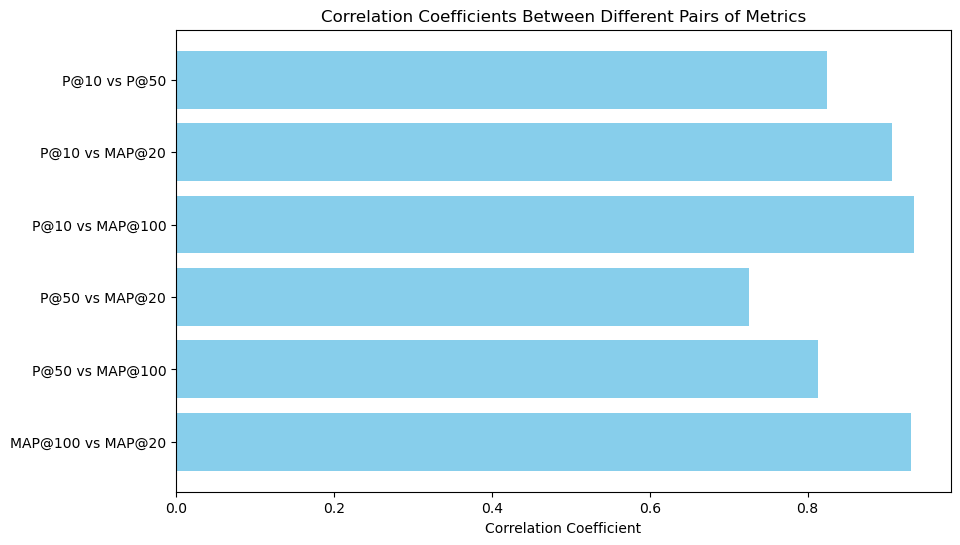

In [110]:
import matplotlib.pyplot as plt

# Your correlation coefficients
correlation_data = {
    'P@10 vs P@50': 0.824226,
    'P@10 vs MAP@20': 0.9067,
    'P@10 vs MAP@100': 0.934751,
    'P@50 vs MAP@20': 0.725128,
    'P@50 vs MAP@100': 0.813456,
    'MAP@100 vs MAP@20': 0.930644
}

# Convert the correlation data into lists
pairs = list(correlation_data.keys())
coefficients = list(correlation_data.values())

# Create bar chart
plt.figure(figsize=(10, 6))
plt.barh(pairs, coefficients, color='skyblue')
plt.xlabel('Correlation Coefficient')
plt.title('Correlation Coefficients Between Different Pairs of Metrics')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest correlation at the top
plt.show()


In [111]:
## Significance Test
import itertools
import scipy.stats as stats

# List to store pairwise comparison results
pairwise_comparisons = []

# Perform pairwise significance testing
for system1, system2 in itertools.combinations(average_scores['system'], 2):
    # Select data for the two systems
    data_system1 = final_results[final_results['system'] == system1]['P@10']
    data_system2 = final_results[final_results['system'] == system2]['P@10']
    
    # Perform significance test (e.g., t-test)
    t_stat, p_val = stats.ttest_rel(data_system1, data_system2)  # Using t-test for paired samples
    
    # Determine if the difference is significant at α = 0.05
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    
    # Append results to pairwise comparisons list
    pairwise_comparisons.append({'System 1': system1, 'System 2': system2, 'p-value': p_val, 'Significance': significance})

# Create DataFrame for pairwise comparisons
pairwise_comparisons_df = pd.DataFrame(pairwise_comparisons)

# Display pairwise comparison results
print("Pairwise Significance Testing Results:")
display(pairwise_comparisons_df)


Pairwise Significance Testing Results:


,System 1,System 2,p-value,Significance
0,GE8MTD2,ok8amxc,2.629125e-01,Not Significant
1,GE8MTD2,Flab8ax,7.442594e-02,Not Significant
2,GE8MTD2,MITSLStd,2.298074e-02,Significant
3,GE8MTD2,apl8c221,4.371641e-02,Significant
4,GE8MTD2,Flab8at,4.160351e-03,Significant
...,...,...,...,...
100,plt8ah2,UB99T,2.072721e-05,Significant
101,plt8ah2,isa25t,8.698715e-08,Significant
102,Dm8Nbn,UB99T,2.793089e-01,Not Significant
103,Dm8Nbn,isa25t,1.079744e-02,Significant


In [112]:
import pandas as pd
import itertools
import scipy.stats as stats

# Assuming average_scores and final_results DataFrames are already defined
# Create an empty DataFrame to store pairwise t-test results
pairwise_t_tests_table = pd.DataFrame(index=average_scores['system'], columns=average_scores['system'])

# Perform pairwise t-tests and fill the table with p-values and significance
for system1, system2 in itertools.combinations(average_scores['system'], 2):
    # Select data for the two systems
    data_system1 = final_results[final_results['system'] == system1]['P@10']
    data_system2 = final_results[final_results['system'] == system2]['P@10']
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(data_system1, data_system2)  # Using t-test for independent samples
    
    # Determine if the difference is significant at α = 0.05
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    
    # Fill the table with p-value and significance
    pairwise_t_tests_table.loc[system1, system2] = f"p={p_val:.4f}, {significance}"
    pairwise_t_tests_table.loc[system2, system1] = f"p={p_val:.4f}, {significance}"  # Since it's symmetric

# Define the CSV filename
csv_filename = 'scores/pairwise_t_test_results.csv'

# Define the separator text or space
separator = "\n\n# Table P@10 \n\n"

# Check if the file already exists
try:
    with open(csv_filename, 'r') as f:
        file_exists = True
except FileNotFoundError:
    file_exists = False

# Open the CSV file in append mode if it exists, else in write mode
with open(csv_filename, 'a' if file_exists else 'w') as f:
    if file_exists:
        # Write the separator to the file
        f.write(separator)
    # Append the DataFrame to the file
    pairwise_t_tests_table.to_csv(f, header=not file_exists)

print("Pairwise t-Test Results (P-values and Significance) for Precision at 10 (P@10):")
display(pairwise_t_tests_table)

Pairwise t-Test Results (P-values and Significance) for Precision at 10 (P@10):


system,GE8MTD2,ok8amxc,Flab8ax,MITSLStd,apl8c221,Flab8at,att99ate,ric8dpn,pir9Aa1,Mer8Adtd2,mds08a2,plt8ah2,Dm8Nbn,UB99T,isa25t
system,,,,,,,,,,,,,,,
GE8MTD2,NaN,"p=0.3923, Not Significant","p=0.2223, Not Significant","p=0.1185, Not Significant","p=0.1250, Not Significant","p=0.0757, Not Significant","p=0.0563, Not Significant","p=0.0124, Significant","p=0.0081, Significant","p=0.0085, Significant","p=0.0030, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
ok8amxc,"p=0.3923, Not Significant",NaN,"p=0.6794, Not Significant","p=0.4770, Not Significant","p=0.4638, Not Significant","p=0.3186, Not Significant","p=0.2537, Not Significant","p=0.0922, Not Significant","p=0.0740, Not Significant","p=0.0704, Not Significant","p=0.0288, Significant","p=0.0005, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
Flab8ax,"p=0.2223, Not Significant","p=0.6794, Not Significant",NaN,"p=0.7966, Not Significant","p=0.7605, Not Significant","p=0.5700, Not Significant","p=0.4771, Not Significant","p=0.2345, Not Significant","p=0.2097, Not Significant","p=0.1932, Not Significant","p=0.0915, Not Significant","p=0.0030, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
MITSLStd,"p=0.1185, Not Significant","p=0.4770, Not Significant","p=0.7966, Not Significant",NaN,"p=0.9485, Not Significant","p=0.7279, Not Significant","p=0.6163, Not Significant","p=0.3192, Not Significant","p=0.2893, Not Significant","p=0.2649, Not Significant","p=0.1255, Not Significant","p=0.0038, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
apl8c221,"p=0.1250, Not Significant","p=0.4638, Not Significant","p=0.7605, Not Significant","p=0.9485, Not Significant",NaN,"p=0.7873, Not Significant","p=0.6774, Not Significant","p=0.3835, Not Significant","p=0.3577, Not Significant","p=0.3268, Not Significant","p=0.1670, Not Significant","p=0.0075, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
Flab8at,"p=0.0757, Not Significant","p=0.3186, Not Significant","p=0.5700, Not Significant","p=0.7279, Not Significant","p=0.7873, Not Significant",NaN,"p=0.8839, Not Significant","p=0.5690, Not Significant","p=0.5486, Not Significant","p=0.5012, Not Significant","p=0.2803, Not Significant","p=0.0185, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
att99ate,"p=0.0563, Not Significant","p=0.2537, Not Significant","p=0.4771, Not Significant","p=0.6163, Not Significant","p=0.6774, Not Significant","p=0.8839, Not Significant",NaN,"p=0.6837, Not Significant","p=0.6681, Not Significant","p=0.6117, Not Significant","p=0.3589, Not Significant","p=0.0288, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
ric8dpn,"p=0.0124, Significant","p=0.0922, Not Significant","p=0.2345, Not Significant","p=0.3192, Not Significant","p=0.3835, Not Significant","p=0.5690, Not Significant","p=0.6837, Not Significant",NaN,"p=1.0000, Not Significant","p=0.9164, Not Significant","p=0.5690, Not Significant","p=0.0494, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
pir9Aa1,"p=0.0081, Significant","p=0.0740, Not Significant","p=0.2097, Not Significant","p=0.2893, Not Significant","p=0.3577, Not Significant","p=0.5486, Not Significant","p=0.6681, Not Significant","p=1.0000, Not Significant",NaN,"p=0.9109, Not Significant","p=0.5459, Not Significant","p=0.0373, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"


In [113]:
import os

# Initialize variables to store all significant system pairs
significant_systems = []

# Iterate through the pairwise t-test results table
for system1 in pairwise_t_tests_table.index:
    for system2 in pairwise_t_tests_table.columns:
        # Skip diagonal elements and empty cells
        if system1 == system2 or pd.isnull(pairwise_t_tests_table.loc[system1, system2]):
            continue
        
        # Extract the p-value from the cell
        p_value_str = pairwise_t_tests_table.loc[system1, system2].split(',')[0]
        p_value = float(p_value_str.split('=')[1])
        
        # Check if the difference is statistically significant at α = 0.05
        if p_value < 0.05:
            significant_systems.append((system1, system2, p_value))

# Print all significant system pairs and their p-values
print("Significant Systems:")
for system1, system2, p_value in significant_systems:
    print(f"{system1} and {system2} (p-value = {p_value:.4f})")

# Calculate the total number of significant pairs
total_significant_pairs = len(significant_systems)
print(f"\nTotal Number of Significant Pairs: {total_significant_pairs}")

Significant Systems:
GE8MTD2 and ric8dpn (p-value = 0.0124)
GE8MTD2 and pir9Aa1 (p-value = 0.0081)
GE8MTD2 and Mer8Adtd2 (p-value = 0.0085)
GE8MTD2 and mds08a2 (p-value = 0.0030)
GE8MTD2 and plt8ah2 (p-value = 0.0000)
GE8MTD2 and Dm8Nbn (p-value = 0.0000)
GE8MTD2 and UB99T (p-value = 0.0000)
GE8MTD2 and isa25t (p-value = 0.0000)
ok8amxc and mds08a2 (p-value = 0.0288)
ok8amxc and plt8ah2 (p-value = 0.0005)
ok8amxc and Dm8Nbn (p-value = 0.0000)
ok8amxc and UB99T (p-value = 0.0000)
ok8amxc and isa25t (p-value = 0.0000)
Flab8ax and plt8ah2 (p-value = 0.0030)
Flab8ax and Dm8Nbn (p-value = 0.0000)
Flab8ax and UB99T (p-value = 0.0000)
Flab8ax and isa25t (p-value = 0.0000)
MITSLStd and plt8ah2 (p-value = 0.0038)
MITSLStd and Dm8Nbn (p-value = 0.0000)
MITSLStd and UB99T (p-value = 0.0000)
MITSLStd and isa25t (p-value = 0.0000)
apl8c221 and plt8ah2 (p-value = 0.0075)
apl8c221 and Dm8Nbn (p-value = 0.0000)
apl8c221 and UB99T (p-value = 0.0000)
apl8c221 and isa25t (p-value = 0.0000)
Flab8at and pl

In [114]:
import pandas as pd
import itertools
import scipy.stats as stats

# Assuming average_scores and final_results DataFrames are already defined
# Create an empty DataFrame to store pairwise t-test results
pairwise_t_tests_table = pd.DataFrame(index=average_scores['system'], columns=average_scores['system'])

# Perform pairwise t-tests and fill the table with p-values and significance
for system1, system2 in itertools.combinations(average_scores['system'], 2):
    # Select data for the two systems
    data_system1 = final_results[final_results['system'] == system1]['P@50']
    data_system2 = final_results[final_results['system'] == system2]['P@50']
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(data_system1, data_system2)  # Using t-test for independent samples
    
    # Determine if the difference is significant at α = 0.05
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    
    # Fill the table with p-value and significance
    pairwise_t_tests_table.loc[system1, system2] = f"p={p_val:.4f}, {significance}"
    pairwise_t_tests_table.loc[system2, system1] = f"p={p_val:.4f}, {significance}"  # Since it's symmetric

# Define the CSV filename
csv_filename = 'scores/pairwise_t_test_results.csv'

# Define the separator text or space
separator = "\n\n# Table P@50 \n\n"

# Check if the file already exists
try:
    with open(csv_filename, 'r') as f:
        file_exists = True
except FileNotFoundError:
    file_exists = False

# Open the CSV file in append mode if it exists, else in write mode
with open(csv_filename, 'a' if file_exists else 'w') as f:
    if file_exists:
        # Write the separator to the file
        f.write(separator)
    # Append the DataFrame to the file
    pairwise_t_tests_table.to_csv(f, header=not file_exists)

print("Pairwise t-Test Results (P-values and Significance) for Precision at 50 (P@50):")
display(pairwise_t_tests_table)


Pairwise t-Test Results (P-values and Significance) for Precision at 50 (P@50):


system,GE8MTD2,ok8amxc,Flab8ax,MITSLStd,apl8c221,Flab8at,att99ate,ric8dpn,pir9Aa1,Mer8Adtd2,mds08a2,plt8ah2,Dm8Nbn,UB99T,isa25t
system,,,,,,,,,,,,,,,
GE8MTD2,NaN,"p=0.9005, Not Significant","p=0.6493, Not Significant","p=0.7947, Not Significant","p=0.3645, Not Significant","p=0.5150, Not Significant","p=0.3411, Not Significant","p=0.0815, Not Significant","p=0.0381, Significant","p=0.0571, Not Significant","p=0.0268, Significant","p=0.0002, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
ok8amxc,"p=0.9005, Not Significant",NaN,"p=0.7319, Not Significant","p=0.8899, Not Significant","p=0.4232, Not Significant","p=0.5853, Not Significant","p=0.3926, Not Significant","p=0.0956, Not Significant","p=0.0443, Significant","p=0.0669, Not Significant","p=0.0311, Significant","p=0.0002, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
Flab8ax,"p=0.6493, Not Significant","p=0.7319, Not Significant",NaN,"p=0.8334, Not Significant","p=0.6813, Not Significant","p=0.8402, Not Significant","p=0.6156, Not Significant","p=0.2096, Not Significant","p=0.1204, Not Significant","p=0.1574, Not Significant","p=0.0827, Not Significant","p=0.0010, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
MITSLStd,"p=0.7947, Not Significant","p=0.8899, Not Significant","p=0.8334, Not Significant",NaN,"p=0.5097, Not Significant","p=0.6772, Not Significant","p=0.4670, Not Significant","p=0.1250, Not Significant","p=0.0610, Not Significant","p=0.0889, Not Significant","p=0.0423, Significant","p=0.0003, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
apl8c221,"p=0.3645, Not Significant","p=0.4232, Not Significant","p=0.6813, Not Significant","p=0.5097, Not Significant",NaN,"p=0.8529, Not Significant","p=0.8870, Not Significant","p=0.3427, Not Significant","p=0.2019, Not Significant","p=0.2596, Not Significant","p=0.1361, Not Significant","p=0.0011, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
Flab8at,"p=0.5150, Not Significant","p=0.5853, Not Significant","p=0.8402, Not Significant","p=0.6772, Not Significant","p=0.8529, Not Significant",NaN,"p=0.7665, Not Significant","p=0.3069, Not Significant","p=0.1942, Not Significant","p=0.2387, Not Significant","p=0.1338, Not Significant","p=0.0022, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
att99ate,"p=0.3411, Not Significant","p=0.3926, Not Significant","p=0.6156, Not Significant","p=0.4670, Not Significant","p=0.8870, Not Significant","p=0.7665, Not Significant",NaN,"p=0.4834, Not Significant","p=0.3391, Not Significant","p=0.3915, Not Significant","p=0.2363, Not Significant","p=0.0058, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
ric8dpn,"p=0.0815, Not Significant","p=0.0956, Not Significant","p=0.2096, Not Significant","p=0.1250, Not Significant","p=0.3427, Not Significant","p=0.3069, Not Significant","p=0.4834, Not Significant",NaN,"p=0.8165, Not Significant","p=0.8637, Not Significant","p=0.5828, Not Significant","p=0.0192, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
pir9Aa1,"p=0.0381, Significant","p=0.0443, Significant","p=0.1204, Not Significant","p=0.0610, Not Significant","p=0.2019, Not Significant","p=0.1942, Not Significant","p=0.3391, Not Significant","p=0.8165, Not Significant",NaN,"p=0.9644, Not Significant","p=0.7078, Not Significant","p=0.0180, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"


In [115]:
import os

# Initialize variables to store all significant system pairs
significant_systems = []

# Iterate through the pairwise t-test results table
for system1 in pairwise_t_tests_table.index:
    for system2 in pairwise_t_tests_table.columns:
        # Skip diagonal elements and empty cells
        if system1 == system2 or pd.isnull(pairwise_t_tests_table.loc[system1, system2]):
            continue
        
        # Extract the p-value from the cell
        p_value_str = pairwise_t_tests_table.loc[system1, system2].split(',')[0]
        p_value = float(p_value_str.split('=')[1])
        
        # Check if the difference is statistically significant at α = 0.05
        if p_value < 0.05:
            significant_systems.append((system1, system2, p_value))

# Print all significant system pairs and their p-values
print("Significant Systems:")
for system1, system2, p_value in significant_systems:
    print(f"{system1} and {system2} (p-value = {p_value:.4f})")

# Calculate the total number of significant pairs
total_significant_pairs = len(significant_systems)
print(f"\nTotal Number of Significant Pairs: {total_significant_pairs}")

Significant Systems:
GE8MTD2 and pir9Aa1 (p-value = 0.0381)
GE8MTD2 and mds08a2 (p-value = 0.0268)
GE8MTD2 and plt8ah2 (p-value = 0.0002)
GE8MTD2 and Dm8Nbn (p-value = 0.0000)
GE8MTD2 and UB99T (p-value = 0.0000)
GE8MTD2 and isa25t (p-value = 0.0000)
ok8amxc and pir9Aa1 (p-value = 0.0443)
ok8amxc and mds08a2 (p-value = 0.0311)
ok8amxc and plt8ah2 (p-value = 0.0002)
ok8amxc and Dm8Nbn (p-value = 0.0000)
ok8amxc and UB99T (p-value = 0.0000)
ok8amxc and isa25t (p-value = 0.0000)
Flab8ax and plt8ah2 (p-value = 0.0010)
Flab8ax and Dm8Nbn (p-value = 0.0000)
Flab8ax and UB99T (p-value = 0.0000)
Flab8ax and isa25t (p-value = 0.0000)
MITSLStd and mds08a2 (p-value = 0.0423)
MITSLStd and plt8ah2 (p-value = 0.0003)
MITSLStd and Dm8Nbn (p-value = 0.0000)
MITSLStd and UB99T (p-value = 0.0000)
MITSLStd and isa25t (p-value = 0.0000)
apl8c221 and plt8ah2 (p-value = 0.0011)
apl8c221 and Dm8Nbn (p-value = 0.0000)
apl8c221 and UB99T (p-value = 0.0000)
apl8c221 and isa25t (p-value = 0.0000)
Flab8at and plt

In [116]:
import pandas as pd
import itertools
import scipy.stats as stats

# Assuming average_scores and final_results DataFrames are already defined
# Create an empty DataFrame to store pairwise t-test results
pairwise_t_tests_table = pd.DataFrame(index=average_scores['system'], columns=average_scores['system'])

# Perform pairwise t-tests and fill the table with p-values and significance
for system1, system2 in itertools.combinations(average_scores['system'], 2):
    # Select data for the two systems
    data_system1 = final_results[final_results['system'] == system1]['MAP@20']
    data_system2 = final_results[final_results['system'] == system2]['MAP@20']
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(data_system1, data_system2)  # Using t-test for independent samples
    
    # Determine if the difference is significant at α = 0.05
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    
    # Fill the table with p-value and significance
    pairwise_t_tests_table.loc[system1, system2] = f"p={p_val:.4f}, {significance}"
    pairwise_t_tests_table.loc[system2, system1] = f"p={p_val:.4f}, {significance}"  # Since it's symmetric

# Define the CSV filename
csv_filename = 'scores/pairwise_t_test_results.csv'

# Define the separator text or space
separator = "\n\n# Table MAP@20 \n\n"

# Check if the file already exists
try:
    with open(csv_filename, 'r') as f:
        file_exists = True
except FileNotFoundError:
    file_exists = False

# Open the CSV file in append mode if it exists, else in write mode
with open(csv_filename, 'a' if file_exists else 'w') as f:
    if file_exists:
        # Write the separator to the file
        f.write(separator)
    # Append the DataFrame to the file
    pairwise_t_tests_table.to_csv(f, header=not file_exists)

print("Pairwise t-Test Results (P-values and Significance) for MAP at 20 (MAP@20):")
display(pairwise_t_tests_table)

Pairwise t-Test Results (P-values and Significance) for MAP at 20 (MAP@20):


system,GE8MTD2,ok8amxc,Flab8ax,MITSLStd,apl8c221,Flab8at,att99ate,ric8dpn,pir9Aa1,Mer8Adtd2,mds08a2,plt8ah2,Dm8Nbn,UB99T,isa25t
system,,,,,,,,,,,,,,,
GE8MTD2,NaN,"p=0.0924, Not Significant","p=0.1279, Not Significant","p=0.0621, Not Significant","p=0.0257, Significant","p=0.0215, Significant","p=0.0029, Significant","p=0.0084, Significant","p=0.0057, Significant","p=0.0017, Significant","p=0.0002, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
ok8amxc,"p=0.0924, Not Significant",NaN,"p=0.9424, Not Significant","p=0.8905, Not Significant","p=0.4971, Not Significant","p=0.4157, Not Significant","p=0.1277, Not Significant","p=0.2892, Not Significant","p=0.2817, Not Significant","p=0.1364, Not Significant","p=0.0282, Significant","p=0.0047, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
Flab8ax,"p=0.1279, Not Significant","p=0.9424, Not Significant",NaN,"p=0.8384, Not Significant","p=0.4752, Not Significant","p=0.3994, Not Significant","p=0.1285, Not Significant","p=0.2823, Not Significant","p=0.2767, Not Significant","p=0.1396, Not Significant","p=0.0316, Significant","p=0.0057, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
MITSLStd,"p=0.0621, Not Significant","p=0.8905, Not Significant","p=0.8384, Not Significant",NaN,"p=0.5692, Not Significant","p=0.4769, Not Significant","p=0.1502, Not Significant","p=0.3379, Not Significant","p=0.3321, Not Significant","p=0.1623, Not Significant","p=0.0334, Significant","p=0.0054, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
apl8c221,"p=0.0257, Significant","p=0.4971, Not Significant","p=0.4752, Not Significant","p=0.5692, Not Significant",NaN,"p=0.8777, Not Significant","p=0.4064, Not Significant","p=0.7332, Not Significant","p=0.7608, Not Significant","p=0.4853, Not Significant","p=0.1599, Not Significant","p=0.0383, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
Flab8at,"p=0.0215, Significant","p=0.4157, Not Significant","p=0.3994, Not Significant","p=0.4769, Not Significant","p=0.8777, Not Significant",NaN,"p=0.5130, Not Significant","p=0.8646, Not Significant","p=0.9009, Not Significant","p=0.6151, Not Significant","p=0.2328, Not Significant","p=0.0638, Not Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
att99ate,"p=0.0029, Significant","p=0.1277, Not Significant","p=0.1285, Not Significant","p=0.1502, Not Significant","p=0.4064, Not Significant","p=0.5130, Not Significant",NaN,"p=0.6012, Not Significant","p=0.5418, Not Significant","p=0.8196, Not Significant","p=0.6219, Not Significant","p=0.2308, Not Significant","p=0.0002, Significant","p=0.0000, Significant","p=0.0000, Significant"
ric8dpn,"p=0.0084, Significant","p=0.2892, Not Significant","p=0.2823, Not Significant","p=0.3379, Not Significant","p=0.7332, Not Significant","p=0.8646, Not Significant","p=0.6012, Not Significant",NaN,"p=0.9517, Not Significant","p=0.7282, Not Significant","p=0.2748, Not Significant","p=0.0725, Not Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
pir9Aa1,"p=0.0057, Significant","p=0.2817, Not Significant","p=0.2767, Not Significant","p=0.3321, Not Significant","p=0.7608, Not Significant","p=0.9009, Not Significant","p=0.5418, Not Significant","p=0.9517, Not Significant",NaN,"p=0.6600, Not Significant","p=0.2182, Not Significant","p=0.0496, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"


In [117]:
import os

# Initialize variables to store all significant system pairs
significant_systems = []

# Iterate through the pairwise t-test results table
for system1 in pairwise_t_tests_table.index:
    for system2 in pairwise_t_tests_table.columns:
        # Skip diagonal elements and empty cells
        if system1 == system2 or pd.isnull(pairwise_t_tests_table.loc[system1, system2]):
            continue
        
        # Extract the p-value from the cell
        p_value_str = pairwise_t_tests_table.loc[system1, system2].split(',')[0]
        p_value = float(p_value_str.split('=')[1])
        
        # Check if the difference is statistically significant at α = 0.05
        if p_value < 0.05:
            significant_systems.append((system1, system2, p_value))

# Print all significant system pairs and their p-values
print("Significant Systems:")
for system1, system2, p_value in significant_systems:
    print(f"{system1} and {system2} (p-value = {p_value:.4f})")

# Calculate the total number of significant pairs
total_significant_pairs = len(significant_systems)
print(f"\nTotal Number of Significant Pairs: {total_significant_pairs}")

Significant Systems:
GE8MTD2 and apl8c221 (p-value = 0.0257)
GE8MTD2 and Flab8at (p-value = 0.0215)
GE8MTD2 and att99ate (p-value = 0.0029)
GE8MTD2 and ric8dpn (p-value = 0.0084)
GE8MTD2 and pir9Aa1 (p-value = 0.0057)
GE8MTD2 and Mer8Adtd2 (p-value = 0.0017)
GE8MTD2 and mds08a2 (p-value = 0.0002)
GE8MTD2 and plt8ah2 (p-value = 0.0000)
GE8MTD2 and Dm8Nbn (p-value = 0.0000)
GE8MTD2 and UB99T (p-value = 0.0000)
GE8MTD2 and isa25t (p-value = 0.0000)
ok8amxc and mds08a2 (p-value = 0.0282)
ok8amxc and plt8ah2 (p-value = 0.0047)
ok8amxc and Dm8Nbn (p-value = 0.0000)
ok8amxc and UB99T (p-value = 0.0000)
ok8amxc and isa25t (p-value = 0.0000)
Flab8ax and mds08a2 (p-value = 0.0316)
Flab8ax and plt8ah2 (p-value = 0.0057)
Flab8ax and Dm8Nbn (p-value = 0.0000)
Flab8ax and UB99T (p-value = 0.0000)
Flab8ax and isa25t (p-value = 0.0000)
MITSLStd and mds08a2 (p-value = 0.0334)
MITSLStd and plt8ah2 (p-value = 0.0054)
MITSLStd and Dm8Nbn (p-value = 0.0000)
MITSLStd and UB99T (p-value = 0.0000)
MITSLStd an

In [118]:
import pandas as pd
import itertools
import scipy.stats as stats

# Assuming average_scores and final_results DataFrames are already defined
# Create an empty DataFrame to store pairwise t-test results
pairwise_t_tests_table = pd.DataFrame(index=average_scores['system'], columns=average_scores['system'])

# Perform pairwise t-tests and fill the table with p-values and significance
for system1, system2 in itertools.combinations(average_scores['system'], 2):
    # Select data for the two systems
    data_system1 = final_results[final_results['system'] == system1]['MAP@100']
    data_system2 = final_results[final_results['system'] == system2]['MAP@100']
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(data_system1, data_system2)  # Using t-test for independent samples
    
    # Determine if the difference is significant at α = 0.05
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    
    # Fill the table with p-value and significance
    pairwise_t_tests_table.loc[system1, system2] = f"p={p_val:.4f}, {significance}"
    pairwise_t_tests_table.loc[system2, system1] = f"p={p_val:.4f}, {significance}"  # Since it's symmetric

# Define the CSV filename
csv_filename = 'scores/pairwise_t_test_results.csv'

# Define the separator text or space
separator = "\n\n# Table MAP@100 \n\n"

# Check if the file already exists
try:
    with open(csv_filename, 'r') as f:
        file_exists = True
except FileNotFoundError:
    file_exists = False

# Open the CSV file in append mode if it exists, else in write mode
with open(csv_filename, 'a' if file_exists else 'w') as f:
    if file_exists:
        # Write the separator to the file
        f.write(separator)
    # Append the DataFrame to the file
    pairwise_t_tests_table.to_csv(f, header=not file_exists)

print("Pairwise t-Test Results (P-values and Significance) for MAP at 100 (MAP@100):")
display(pairwise_t_tests_table)

Pairwise t-Test Results (P-values and Significance) for MAP at 100 (MAP@100):


system,GE8MTD2,ok8amxc,Flab8ax,MITSLStd,apl8c221,Flab8at,att99ate,ric8dpn,pir9Aa1,Mer8Adtd2,mds08a2,plt8ah2,Dm8Nbn,UB99T,isa25t
system,,,,,,,,,,,,,,,
GE8MTD2,NaN,"p=0.2186, Not Significant","p=0.1522, Not Significant","p=0.1316, Not Significant","p=0.0580, Not Significant","p=0.0643, Not Significant","p=0.0193, Significant","p=0.0054, Significant","p=0.0034, Significant","p=0.0026, Significant","p=0.0005, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
ok8amxc,"p=0.2186, Not Significant",NaN,"p=0.7975, Not Significant","p=0.7825, Not Significant","p=0.4741, Not Significant","p=0.4840, Not Significant","p=0.2195, Not Significant","p=0.1210, Not Significant","p=0.0967, Not Significant","p=0.0796, Not Significant","p=0.0230, Significant","p=0.0003, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
Flab8ax,"p=0.1522, Not Significant","p=0.7975, Not Significant",NaN,"p=0.9946, Not Significant","p=0.6607, Not Significant","p=0.6666, Not Significant","p=0.3433, Not Significant","p=0.2219, Not Significant","p=0.1881, Not Significant","p=0.1596, Not Significant","p=0.0546, Not Significant","p=0.0013, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
MITSLStd,"p=0.1316, Not Significant","p=0.7825, Not Significant","p=0.9946, Not Significant",NaN,"p=0.6513, Not Significant","p=0.6579, Not Significant","p=0.3271, Not Significant","p=0.2018, Not Significant","p=0.1676, Not Significant","p=0.1404, Not Significant","p=0.0444, Significant","p=0.0008, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
apl8c221,"p=0.0580, Not Significant","p=0.4741, Not Significant","p=0.6607, Not Significant","p=0.6513, Not Significant",NaN,"p=0.9982, Not Significant","p=0.5931, Not Significant","p=0.4426, Not Significant","p=0.3943, Not Significant","p=0.3443, Not Significant","p=0.1373, Not Significant","p=0.0050, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
Flab8at,"p=0.0643, Not Significant","p=0.4840, Not Significant","p=0.6666, Not Significant","p=0.6579, Not Significant","p=0.9982, Not Significant",NaN,"p=0.6026, Not Significant","p=0.4563, Not Significant","p=0.4092, Not Significant","p=0.3592, Not Significant","p=0.1486, Not Significant","p=0.0063, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
att99ate,"p=0.0193, Significant","p=0.2195, Not Significant","p=0.3433, Not Significant","p=0.3271, Not Significant","p=0.5931, Not Significant","p=0.6026, Not Significant",NaN,"p=0.8682, Not Significant","p=0.8186, Not Significant","p=0.7480, Not Significant","p=0.3908, Not Significant","p=0.0325, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
ric8dpn,"p=0.0054, Significant","p=0.1210, Not Significant","p=0.2219, Not Significant","p=0.2018, Not Significant","p=0.4426, Not Significant","p=0.4563, Not Significant","p=0.8682, Not Significant",NaN,"p=0.9465, Not Significant","p=0.8635, Not Significant","p=0.4352, Not Significant","p=0.0266, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"
pir9Aa1,"p=0.0034, Significant","p=0.0967, Not Significant","p=0.1881, Not Significant","p=0.1676, Not Significant","p=0.3943, Not Significant","p=0.4092, Not Significant","p=0.8186, Not Significant","p=0.9465, Not Significant",NaN,"p=0.9134, Not Significant","p=0.4598, Not Significant","p=0.0262, Significant","p=0.0000, Significant","p=0.0000, Significant","p=0.0000, Significant"


In [119]:
import os

# Initialize variables to store all significant system pairs
significant_systems = []

# Iterate through the pairwise t-test results table
for system1 in pairwise_t_tests_table.index:
    for system2 in pairwise_t_tests_table.columns:
        # Skip diagonal elements and empty cells
        if system1 == system2 or pd.isnull(pairwise_t_tests_table.loc[system1, system2]):
            continue
        
        # Extract the p-value from the cell
        p_value_str = pairwise_t_tests_table.loc[system1, system2].split(',')[0]
        p_value = float(p_value_str.split('=')[1])
        
        # Check if the difference is statistically significant at α = 0.05
        if p_value < 0.05:
            significant_systems.append((system1, system2, p_value))

# Print all significant system pairs and their p-values
print("Significant Systems:")
for system1, system2, p_value in significant_systems:
    print(f"{system1} and {system2} (p-value = {p_value:.4f})")

# Calculate the total number of significant pairs
total_significant_pairs = len(significant_systems)
print(f"\nTotal Number of Significant Pairs: {total_significant_pairs}")

Significant Systems:
GE8MTD2 and att99ate (p-value = 0.0193)
GE8MTD2 and ric8dpn (p-value = 0.0054)
GE8MTD2 and pir9Aa1 (p-value = 0.0034)
GE8MTD2 and Mer8Adtd2 (p-value = 0.0026)
GE8MTD2 and mds08a2 (p-value = 0.0005)
GE8MTD2 and plt8ah2 (p-value = 0.0000)
GE8MTD2 and Dm8Nbn (p-value = 0.0000)
GE8MTD2 and UB99T (p-value = 0.0000)
GE8MTD2 and isa25t (p-value = 0.0000)
ok8amxc and mds08a2 (p-value = 0.0230)
ok8amxc and plt8ah2 (p-value = 0.0003)
ok8amxc and Dm8Nbn (p-value = 0.0000)
ok8amxc and UB99T (p-value = 0.0000)
ok8amxc and isa25t (p-value = 0.0000)
Flab8ax and plt8ah2 (p-value = 0.0013)
Flab8ax and Dm8Nbn (p-value = 0.0000)
Flab8ax and UB99T (p-value = 0.0000)
Flab8ax and isa25t (p-value = 0.0000)
MITSLStd and mds08a2 (p-value = 0.0444)
MITSLStd and plt8ah2 (p-value = 0.0008)
MITSLStd and Dm8Nbn (p-value = 0.0000)
MITSLStd and UB99T (p-value = 0.0000)
MITSLStd and isa25t (p-value = 0.0000)
apl8c221 and plt8ah2 (p-value = 0.0050)
apl8c221 and Dm8Nbn (p-value = 0.0000)
apl8c221 an

In [122]:
import pandas as pd
import itertools
import scipy.stats as stats

# Assuming average_scores and final_results DataFrames are already defined
# Create an empty DataFrame to store pairwise t-test results
pairwise_t_tests_table = pd.DataFrame(index=average_scores['system'], columns=average_scores['system'])

# Perform pairwise t-tests and fill the table with p-values
for system1, system2 in itertools.combinations(average_scores['system'], 2):
    # Select data for the two systems
    data_system1 = final_results[final_results['system'] == system1]['MAP@100']
    data_system2 = final_results[final_results['system'] == system2]['MAP@100']
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(data_system1, data_system2)  # Using t-test for independent samples
    
    # Fill the table with p-value
    pairwise_t_tests_table.loc[system1, system2] = f"{p_val:.4f}"
    pairwise_t_tests_table.loc[system2, system1] = f"{p_val:.4f}"  # Since it's symmetric


print("Pairwise t-Test Results (P-values) for MAP at 100 (MAP@100):")
display(pairwise_t_tests_table)

Pairwise t-Test Results (P-values) for MAP at 100 (MAP@100):


system,GE8MTD2,ok8amxc,Flab8ax,MITSLStd,apl8c221,Flab8at,att99ate,ric8dpn,pir9Aa1,Mer8Adtd2,mds08a2,plt8ah2,Dm8Nbn,UB99T,isa25t
system,,,,,,,,,,,,,,,
GE8MTD2,NaN,0.2186,0.1522,0.1316,0.0580,0.0643,0.0193,0.0054,0.0034,0.0026,0.0005,0.0000,0.0000,0.0000,0.0000
ok8amxc,0.2186,NaN,0.7975,0.7825,0.4741,0.4840,0.2195,0.1210,0.0967,0.0796,0.0230,0.0003,0.0000,0.0000,0.0000
Flab8ax,0.1522,0.7975,NaN,0.9946,0.6607,0.6666,0.3433,0.2219,0.1881,0.1596,0.0546,0.0013,0.0000,0.0000,0.0000
MITSLStd,0.1316,0.7825,0.9946,NaN,0.6513,0.6579,0.3271,0.2018,0.1676,0.1404,0.0444,0.0008,0.0000,0.0000,0.0000
apl8c221,0.0580,0.4741,0.6607,0.6513,NaN,0.9982,0.5931,0.4426,0.3943,0.3443,0.1373,0.0050,0.0000,0.0000,0.0000
Flab8at,0.0643,0.4840,0.6666,0.6579,0.9982,NaN,0.6026,0.4563,0.4092,0.3592,0.1486,0.0063,0.0000,0.0000,0.0000
att99ate,0.0193,0.2195,0.3433,0.3271,0.5931,0.6026,NaN,0.8682,0.8186,0.7480,0.3908,0.0325,0.0000,0.0000,0.0000
ric8dpn,0.0054,0.1210,0.2219,0.2018,0.4426,0.4563,0.8682,NaN,0.9465,0.8635,0.4352,0.0266,0.0000,0.0000,0.0000
pir9Aa1,0.0034,0.0967,0.1881,0.1676,0.3943,0.4092,0.8186,0.9465,NaN,0.9134,0.4598,0.0262,0.0000,0.0000,0.0000
